In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import numpy as np
import torchvision.models.segmentation as models
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.colors as mcolors

In [27]:
class GoalDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        self.samples = self._collect_samples()

    def _collect_samples(self):
        files = os.listdir(self.root_dir)
        image_files = [f for f in files if f.endswith('.jpg') and '___' not in f]

        samples = []
        for img_file in image_files:
            img_path = os.path.join(self.root_dir, img_file)
            mask_name = img_file + '___fuse.png'
            mask_path = os.path.join(self.root_dir, mask_name)

            if os.path.exists(mask_path):
                samples.append((img_path, mask_path))
            else:
                print(f"[WARNING] Маска не найдена для: {img_file}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
    
        if self.transform:
            image = self.transform(image)
    
        if self.target_transform:
            mask = self.target_transform(mask)
    
        mask = np.array(mask, dtype=np.uint8)
    
        # Применим маппинг значений в классы
        label_mapping = {0: 0, 67: 1, 90: 2, 97: 3, 129: 4, 170: 5, 213: 6, 214: 7}
        remapped_mask = np.zeros_like(mask)
        for k, v in label_mapping.items():
            remapped_mask[mask == k] = v
    
        mask = torch.from_numpy(remapped_mask).long()
    
        return image, mask

In [28]:
transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225)),
])

target_transform = Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)

dataset = GoalDataset("/kaggle/input/football-semantic-segmentation/images", transform=transform, target_transform=target_transform)

train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [29]:
for _, mask in train_dataset:
    print("Mask unique values:", torch.unique(mask))
    break

Mask unique values: tensor([1, 2, 3, 4, 5, 6, 7])


torch.Size([3, 256, 256])
torch.Size([256, 256])
Sample 1 — unique mask values: tensor([1, 2, 3, 4, 5, 6, 7])


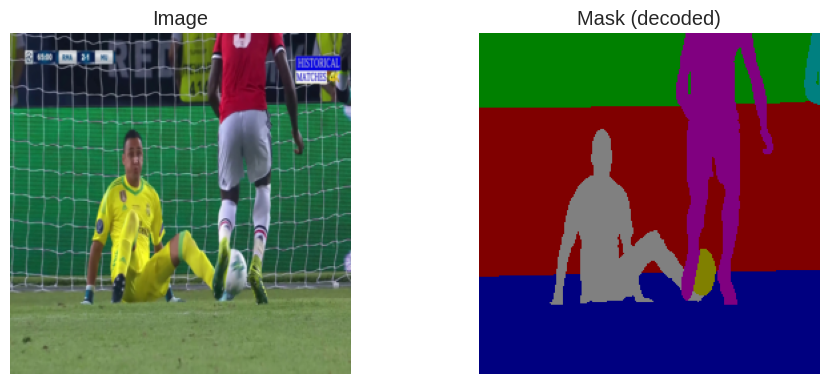

torch.Size([3, 256, 256])
torch.Size([256, 256])
Sample 2 — unique mask values: tensor([0, 1, 2, 3, 4, 5, 6])


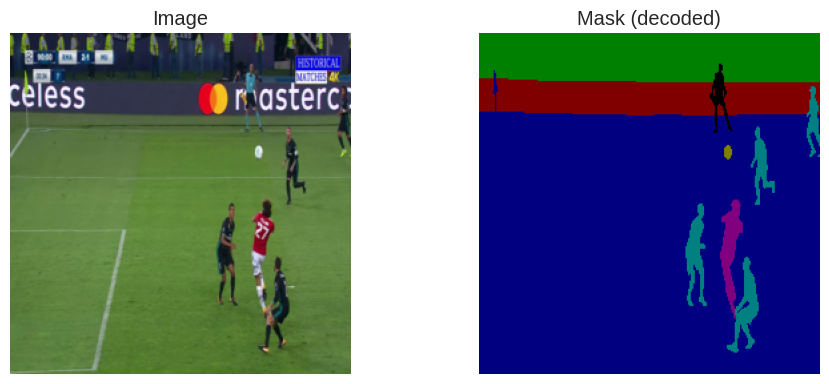

torch.Size([3, 256, 256])
torch.Size([256, 256])
Sample 3 — unique mask values: tensor([1, 2, 3, 4, 5, 6])


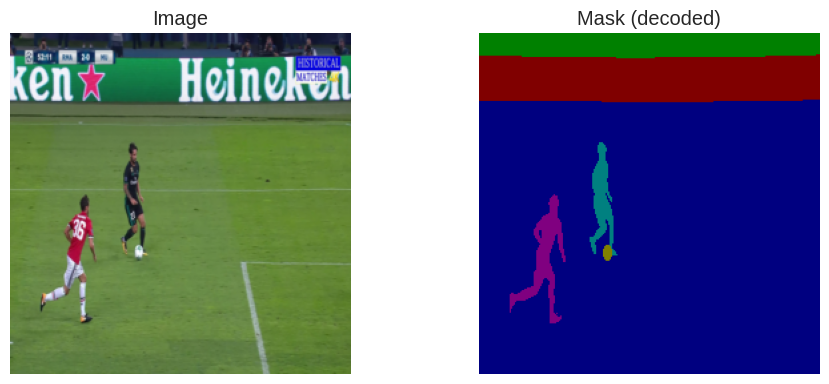

torch.Size([3, 256, 256])
torch.Size([256, 256])
Sample 4 — unique mask values: tensor([0, 1, 2, 3, 4, 5, 6, 7])


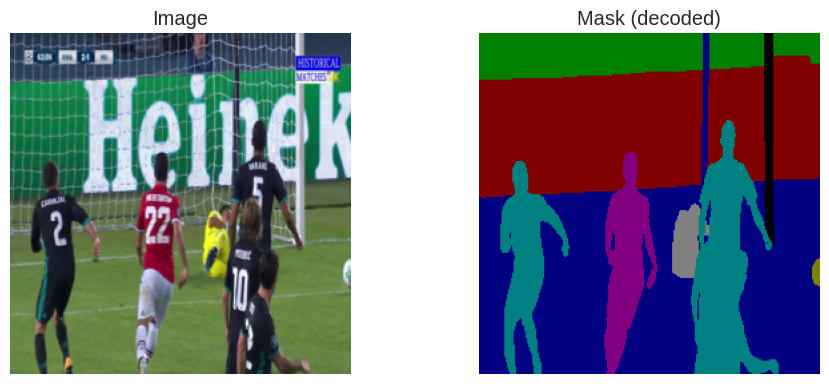

torch.Size([3, 256, 256])
torch.Size([256, 256])
Sample 5 — unique mask values: tensor([1, 2, 3, 4, 5, 6, 7])


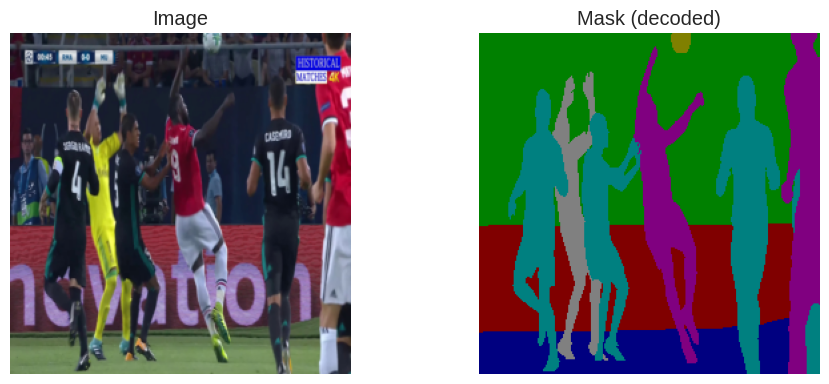

In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import torch

# Цветовая карта (можно заменить на свою)
# Например, для 11 классов (RGB)
COLORS = np.array([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
], dtype=np.uint8)

def decode_segmap(mask):
    """Принимает torch.Tensor [H, W] с классами, возвращает RGB np.array"""
    mask_np = mask.numpy()
    return COLORS[mask_np]

# Вывести N примеров из train_dataset
def show_dataset_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]  # image: [3, H, W], mask: [H, W]
        print(image.shape)
        print(mask.shape)

        # Обратим нормализацию для отображения
        image_vis = image.clone()
        image_vis = image_vis * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_vis = image_vis + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        image_vis = torch.clamp(image_vis, 0, 1)

        image_vis = TF.to_pil_image(image_vis)
        mask_vis = decode_segmap(mask)

        print(f"Sample {i + 1} — unique mask values: {torch.unique(mask)}")

        # Визуализация
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(image_vis)
        axs[0].set_title("Image")
        axs[0].axis("off")

        axs[1].imshow(mask_vis)
        axs[1].set_title("Mask (decoded)")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

# Вызов функции
show_dataset_samples(train_dataset, num_samples=5)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.deeplabv3_resnet101(pretrained=False, num_classes=11)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 217MB/s] 


In [53]:
def compute_iou(preds, labels, num_classes=11):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)

In [54]:
losses = []
train_ious = []
val_ious = []

for epoch in range(80):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    num_batches = 0

    for inputs, labels in (bar := tqdm(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)['out']

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

        preds = torch.argmax(outputs, dim=1)
        iou = compute_iou(preds.cpu(), labels.cpu(), num_classes=11)
        running_iou += iou
        bar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | IoU: {iou:.4f}")

    # Валидация
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)['out']
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    val_iou = compute_iou(all_preds, all_labels, num_classes=11)

    mean_loss = running_loss / num_batches
    mean_iou = running_iou / num_batches

    print(f"[Epoch {epoch+1}] Loss: {mean_loss:.4f}, Train IoU: {mean_iou:.4f}, Val IoU: {val_iou:.4f}")

    losses.append(mean_loss)
    train_ious.append(mean_iou)
    val_ious.append(val_iou)

Epoch 1 | Loss: 1.0701 | IoU: 0.2780: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 1] Loss: 1.5152, Train IoU: 0.2020, Val IoU: 0.3315


Epoch 2 | Loss: 0.6530 | IoU: 0.3973: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 2] Loss: 0.8221, Train IoU: 0.3670, Val IoU: 0.3968


Epoch 3 | Loss: 0.5435 | IoU: 0.4404: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 3] Loss: 0.6001, Train IoU: 0.4206, Val IoU: 0.4209


Epoch 4 | Loss: 0.5545 | IoU: 0.4400: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


[Epoch 4] Loss: 0.5416, Train IoU: 0.4485, Val IoU: 0.4440


Epoch 5 | Loss: 0.4218 | IoU: 0.4792: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 5] Loss: 0.4486, Train IoU: 0.4693, Val IoU: 0.4661


Epoch 6 | Loss: 0.3838 | IoU: 0.4947: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 6] Loss: 0.4208, Train IoU: 0.5040, Val IoU: 0.5160


Epoch 7 | Loss: 0.3446 | IoU: 0.5737: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


[Epoch 7] Loss: 0.3623, Train IoU: 0.5414, Val IoU: 0.5682


Epoch 8 | Loss: 0.3821 | IoU: 0.6075: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 8] Loss: 0.3390, Train IoU: 0.5821, Val IoU: 0.5790


Epoch 9 | Loss: 0.2897 | IoU: 0.6096: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


[Epoch 9] Loss: 0.3234, Train IoU: 0.5993, Val IoU: 0.5963


Epoch 10 | Loss: 0.2762 | IoU: 0.6663: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 10] Loss: 0.2889, Train IoU: 0.6302, Val IoU: 0.6143


Epoch 11 | Loss: 0.3649 | IoU: 0.6339: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 11] Loss: 0.3007, Train IoU: 0.6412, Val IoU: 0.6276


Epoch 12 | Loss: 0.2559 | IoU: 0.6537: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 12] Loss: 0.2694, Train IoU: 0.6399, Val IoU: 0.6335


Epoch 13 | Loss: 0.2438 | IoU: 0.6054: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 13] Loss: 0.2811, Train IoU: 0.6429, Val IoU: 0.6191


Epoch 14 | Loss: 0.2648 | IoU: 0.6650: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 14] Loss: 0.2464, Train IoU: 0.6436, Val IoU: 0.6444


Epoch 15 | Loss: 0.2191 | IoU: 0.6713: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


[Epoch 15] Loss: 0.2495, Train IoU: 0.6587, Val IoU: 0.6473


Epoch 16 | Loss: 0.2153 | IoU: 0.5810: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 16] Loss: 0.2134, Train IoU: 0.6657, Val IoU: 0.6496


Epoch 17 | Loss: 0.1908 | IoU: 0.7457: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 17] Loss: 0.2099, Train IoU: 0.6772, Val IoU: 0.6537


Epoch 18 | Loss: 0.1783 | IoU: 0.7048: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 18] Loss: 0.1920, Train IoU: 0.6907, Val IoU: 0.6574


Epoch 19 | Loss: 0.2160 | IoU: 0.7051: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 19] Loss: 0.1954, Train IoU: 0.6892, Val IoU: 0.6604


Epoch 20 | Loss: 0.2038 | IoU: 0.6610: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 20] Loss: 0.1972, Train IoU: 0.6816, Val IoU: 0.6630


Epoch 21 | Loss: 0.1925 | IoU: 0.7036: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


[Epoch 21] Loss: 0.2021, Train IoU: 0.6810, Val IoU: 0.6589


Epoch 22 | Loss: 0.1930 | IoU: 0.7063: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 22] Loss: 0.1837, Train IoU: 0.6994, Val IoU: 0.6696


Epoch 23 | Loss: 0.1841 | IoU: 0.6600: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 23] Loss: 0.1667, Train IoU: 0.7038, Val IoU: 0.6675


Epoch 24 | Loss: 0.1573 | IoU: 0.7367: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 24] Loss: 0.1630, Train IoU: 0.7107, Val IoU: 0.6673


Epoch 25 | Loss: 0.1997 | IoU: 0.7578: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 25] Loss: 0.1659, Train IoU: 0.7121, Val IoU: 0.6664


Epoch 26 | Loss: 0.1518 | IoU: 0.7476: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 26] Loss: 0.1584, Train IoU: 0.7161, Val IoU: 0.6723


Epoch 27 | Loss: 0.1517 | IoU: 0.7140: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 27] Loss: 0.1602, Train IoU: 0.7263, Val IoU: 0.6750


Epoch 28 | Loss: 0.1682 | IoU: 0.6930: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 28] Loss: 0.1587, Train IoU: 0.7210, Val IoU: 0.6688


Epoch 29 | Loss: 0.1623 | IoU: 0.7271: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 29] Loss: 0.1444, Train IoU: 0.7334, Val IoU: 0.6778


Epoch 30 | Loss: 0.2316 | IoU: 0.7743: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 30] Loss: 0.1557, Train IoU: 0.7359, Val IoU: 0.6762


Epoch 31 | Loss: 0.1401 | IoU: 0.7314: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 31] Loss: 0.1410, Train IoU: 0.7564, Val IoU: 0.6832


Epoch 32 | Loss: 0.1710 | IoU: 0.7729: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


[Epoch 32] Loss: 0.1381, Train IoU: 0.7459, Val IoU: 0.6779


Epoch 33 | Loss: 0.2146 | IoU: 0.6834: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 33] Loss: 0.1421, Train IoU: 0.7575, Val IoU: 0.6956


Epoch 34 | Loss: 0.1253 | IoU: 0.7929: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 34] Loss: 0.1295, Train IoU: 0.7674, Val IoU: 0.6968


Epoch 35 | Loss: 0.1273 | IoU: 0.7268: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 35] Loss: 0.1288, Train IoU: 0.7553, Val IoU: 0.7210


Epoch 36 | Loss: 0.1206 | IoU: 0.7087: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 36] Loss: 0.1278, Train IoU: 0.7763, Val IoU: 0.7219


Epoch 37 | Loss: 0.1164 | IoU: 0.7314: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 37] Loss: 0.1320, Train IoU: 0.7699, Val IoU: 0.7291


Epoch 38 | Loss: 0.1347 | IoU: 0.7949: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 38] Loss: 0.1305, Train IoU: 0.7689, Val IoU: 0.7285


Epoch 39 | Loss: 0.1153 | IoU: 0.8191: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 39] Loss: 0.1245, Train IoU: 0.7875, Val IoU: 0.7332


Epoch 40 | Loss: 0.1234 | IoU: 0.8268: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 40] Loss: 0.1221, Train IoU: 0.7828, Val IoU: 0.7343


Epoch 41 | Loss: 0.1432 | IoU: 0.8039: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 41] Loss: 0.1197, Train IoU: 0.7872, Val IoU: 0.7272


Epoch 42 | Loss: 0.1121 | IoU: 0.7886: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


[Epoch 42] Loss: 0.1189, Train IoU: 0.7911, Val IoU: 0.7319


Epoch 43 | Loss: 0.1069 | IoU: 0.8109: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 43] Loss: 0.1178, Train IoU: 0.7925, Val IoU: 0.7411


Epoch 44 | Loss: 0.1250 | IoU: 0.7542: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 44] Loss: 0.1173, Train IoU: 0.8024, Val IoU: 0.7338


Epoch 45 | Loss: 0.0872 | IoU: 0.7063: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 45] Loss: 0.1124, Train IoU: 0.7846, Val IoU: 0.7376


Epoch 46 | Loss: 0.1132 | IoU: 0.8351: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 46] Loss: 0.1106, Train IoU: 0.8024, Val IoU: 0.7373


Epoch 47 | Loss: 0.1285 | IoU: 0.8326: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


[Epoch 47] Loss: 0.1083, Train IoU: 0.7955, Val IoU: 0.7430


Epoch 48 | Loss: 0.1116 | IoU: 0.7577: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 48] Loss: 0.1128, Train IoU: 0.7976, Val IoU: 0.7410


Epoch 49 | Loss: 0.1014 | IoU: 0.7796: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 49] Loss: 0.1134, Train IoU: 0.8011, Val IoU: 0.7378


Epoch 50 | Loss: 0.1033 | IoU: 0.8454: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 50] Loss: 0.1071, Train IoU: 0.8049, Val IoU: 0.7436


Epoch 51 | Loss: 0.1131 | IoU: 0.7377: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 51] Loss: 0.1088, Train IoU: 0.7999, Val IoU: 0.7395


Epoch 52 | Loss: 0.1152 | IoU: 0.8263: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 52] Loss: 0.1071, Train IoU: 0.8011, Val IoU: 0.7471


Epoch 53 | Loss: 0.0876 | IoU: 0.8576: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 53] Loss: 0.1074, Train IoU: 0.8052, Val IoU: 0.7464


Epoch 54 | Loss: 0.1229 | IoU: 0.8000: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


[Epoch 54] Loss: 0.1045, Train IoU: 0.8163, Val IoU: 0.7368


Epoch 55 | Loss: 0.1094 | IoU: 0.7807: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 55] Loss: 0.1048, Train IoU: 0.8152, Val IoU: 0.7563


Epoch 56 | Loss: 0.1146 | IoU: 0.7916: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 56] Loss: 0.1007, Train IoU: 0.8273, Val IoU: 0.7345


Epoch 57 | Loss: 0.2063 | IoU: 0.7584: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 57] Loss: 0.1122, Train IoU: 0.8083, Val IoU: 0.7523


Epoch 58 | Loss: 0.0953 | IoU: 0.8096: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 58] Loss: 0.0992, Train IoU: 0.8259, Val IoU: 0.7465


Epoch 59 | Loss: 0.1063 | IoU: 0.7767: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 59] Loss: 0.0999, Train IoU: 0.8128, Val IoU: 0.7408


Epoch 60 | Loss: 0.0917 | IoU: 0.8799: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 60] Loss: 0.1055, Train IoU: 0.8176, Val IoU: 0.7521


Epoch 61 | Loss: 0.0940 | IoU: 0.8045: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 61] Loss: 0.0971, Train IoU: 0.8141, Val IoU: 0.7473


Epoch 62 | Loss: 0.0968 | IoU: 0.8042: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 62] Loss: 0.0957, Train IoU: 0.8215, Val IoU: 0.7597


Epoch 63 | Loss: 0.0825 | IoU: 0.8379: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


[Epoch 63] Loss: 0.0975, Train IoU: 0.8166, Val IoU: 0.7413


Epoch 64 | Loss: 0.0929 | IoU: 0.7940: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 64] Loss: 0.0952, Train IoU: 0.8220, Val IoU: 0.7480


Epoch 65 | Loss: 0.0837 | IoU: 0.8960: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 65] Loss: 0.0941, Train IoU: 0.8258, Val IoU: 0.7585


Epoch 66 | Loss: 0.1112 | IoU: 0.8300: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 66] Loss: 0.0950, Train IoU: 0.8247, Val IoU: 0.7601


Epoch 67 | Loss: 0.0879 | IoU: 0.8584: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 67] Loss: 0.0921, Train IoU: 0.8201, Val IoU: 0.7556


Epoch 68 | Loss: 0.1048 | IoU: 0.8257: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 68] Loss: 0.0935, Train IoU: 0.8321, Val IoU: 0.7531


Epoch 69 | Loss: 0.0924 | IoU: 0.8337: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 69] Loss: 0.0906, Train IoU: 0.8286, Val IoU: 0.7580


Epoch 70 | Loss: 0.0889 | IoU: 0.8317: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 70] Loss: 0.0933, Train IoU: 0.8329, Val IoU: 0.7468


Epoch 71 | Loss: 0.1045 | IoU: 0.8016: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 71] Loss: 0.0923, Train IoU: 0.8242, Val IoU: 0.7535


Epoch 72 | Loss: 0.0967 | IoU: 0.8200: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 72] Loss: 0.0888, Train IoU: 0.8299, Val IoU: 0.7511


Epoch 73 | Loss: 0.0921 | IoU: 0.8454: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 73] Loss: 0.0885, Train IoU: 0.8305, Val IoU: 0.7590


Epoch 74 | Loss: 0.0943 | IoU: 0.7698: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 74] Loss: 0.0884, Train IoU: 0.8291, Val IoU: 0.7686


Epoch 75 | Loss: 0.0892 | IoU: 0.8002: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 75] Loss: 0.0873, Train IoU: 0.8368, Val IoU: 0.7597


Epoch 76 | Loss: 0.0871 | IoU: 0.8607: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 76] Loss: 0.0863, Train IoU: 0.8383, Val IoU: 0.7615


Epoch 77 | Loss: 0.0763 | IoU: 0.8334: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 77] Loss: 0.0866, Train IoU: 0.8182, Val IoU: 0.7627


Epoch 78 | Loss: 0.1085 | IoU: 0.8633: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


[Epoch 78] Loss: 0.0898, Train IoU: 0.8338, Val IoU: 0.7670


Epoch 79 | Loss: 0.0916 | IoU: 0.8036: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Epoch 79] Loss: 0.0884, Train IoU: 0.8285, Val IoU: 0.7577


Epoch 80 | Loss: 0.0868 | IoU: 0.8771: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


[Epoch 80] Loss: 0.0849, Train IoU: 0.8371, Val IoU: 0.7600


In [55]:
def plot_training_and_validation(losses, train_fs, valid_fs, title='Learning NN by epochs'):
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = (16, 8)
    plt.rcParams['font.size'] = 12

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.subplots_adjust(hspace=0.1)

    # --- Лоссы ---
    loss_color = '#FF6B6B'
    ax1.plot(losses, color=loss_color, alpha=0.7, linewidth=2.5, label='Train Loss')
    ax1.set_ylabel('Loss', color=loss_color)
    ax1.tick_params(axis='y', labelcolor=loss_color)
    ax1.set_yscale('log')

    window_size = max(1, len(losses)//20)
    smooth_loss = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(np.arange(window_size//2, len(losses)-window_size//2), smooth_loss, 
             color='#EB5353', linewidth=2, label='Smoothed Loss')

    ax1.axhline(min(losses), color=loss_color, linestyle='--', alpha=0.5)
    ax1.legend(loc='upper right')

    # --- F1-score ---
    metric_train_color = '#36A2EB'
    metric_valid_color = '#FFA500'  # оранжевый для валидации

    epochs = range(1, len(train_fs) + 1)

    ax2.plot(epochs, train_fs, color=metric_train_color, linewidth=2.5, label='Train IoU-score')
    ax2.plot(epochs, valid_fs, color=metric_valid_color, linewidth=2.5, linestyle='--', label='Valid IoU-score')

    ax2.set_ylabel('IoU-score')
    ax2.set_xlabel('Epochs')
    ax2.tick_params(axis='y')
    ax2.axhline(max(valid_fs), color=metric_valid_color, linestyle='--', alpha=0.5)
    ax2.axhline(max(train_fs), color=metric_train_color, linestyle='--', alpha=0.5)
    ax2.legend(loc='lower right')

    plt.suptitle(title, y=0.97, fontsize=14)
    plt.show()

/tmp/ipykernel_31/81115342.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


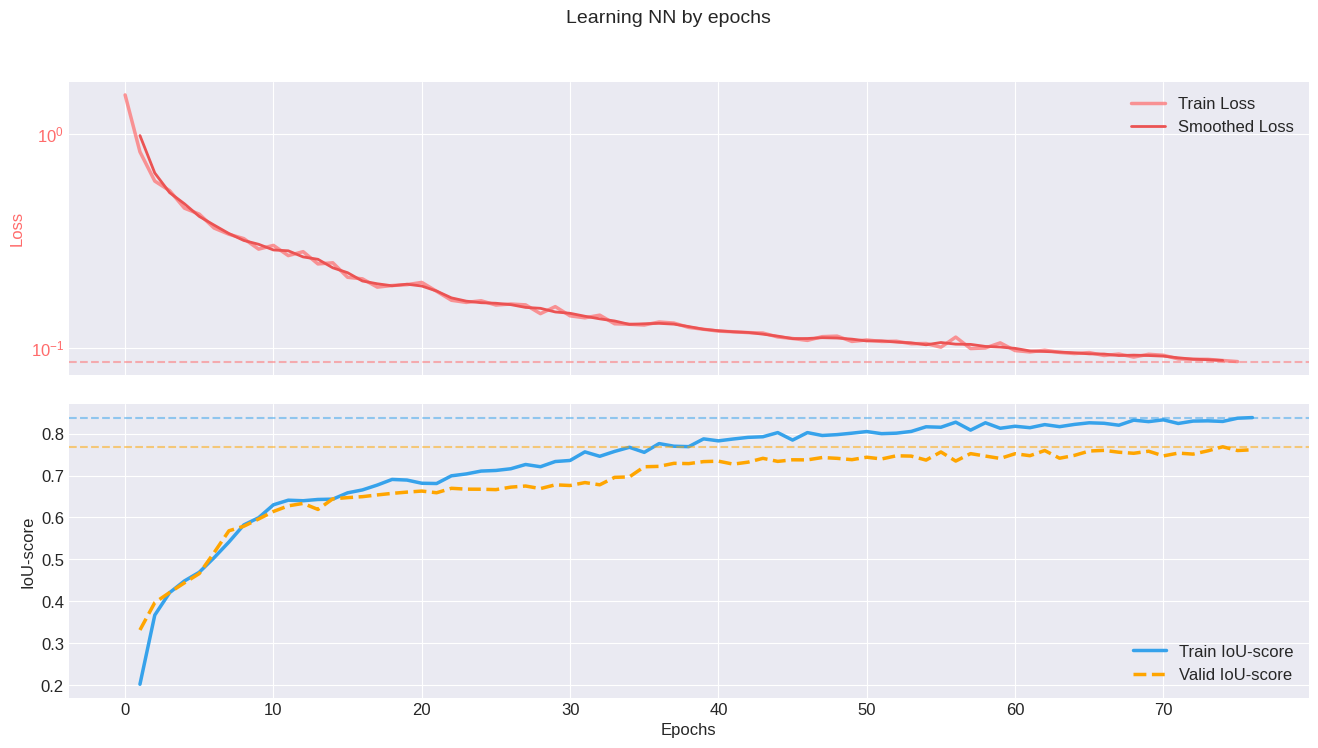

In [57]:
plot_training_and_validation(losses[:76], train_ious[:76], val_ious[:76])

In [58]:
COLORS = np.array([
    [0, 0, 0],         
    [128, 0, 0],   
    [0, 128, 0],     
    [128, 128, 0],  
    [0, 0, 128],     
    [128, 0, 128],    
    [0, 128, 128], 
    [128, 128, 128], 
    [64, 0, 0], 
    [192, 0, 0], 
    [64, 128, 0],    
], dtype=np.uint8)

def decode_segmap(mask):
    """Переводит маску (H, W) с индексами классов в RGB изображение"""
    color_mask = COLORS[mask]
    return color_mask

In [59]:
def visualize_predictions(model, dataset, num_samples=3, title="Train"):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    # если 1 пример, axs будет одномерным
    if num_samples == 1:
        axs = [axs]

    for i in range(num_samples):
        image, mask = dataset[i]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        image_np = TF.to_pil_image(image.cpu())
        gt_mask = mask.cpu().numpy()
        pred_mask = pred

        axs[i][0].imshow(image_np)
        axs[i][0].set_title('Image')
        axs[i][0].axis('off')

        axs[i][1].imshow(decode_segmap(gt_mask))
        axs[i][1].set_title('Ground Truth')
        axs[i][1].axis('off')

        axs[i][2].imshow(decode_segmap(pred_mask))
        axs[i][2].set_title('Prediction')
        axs[i][2].axis('off')

    plt.suptitle(f"{title} Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

Visualizing predictions on train set:


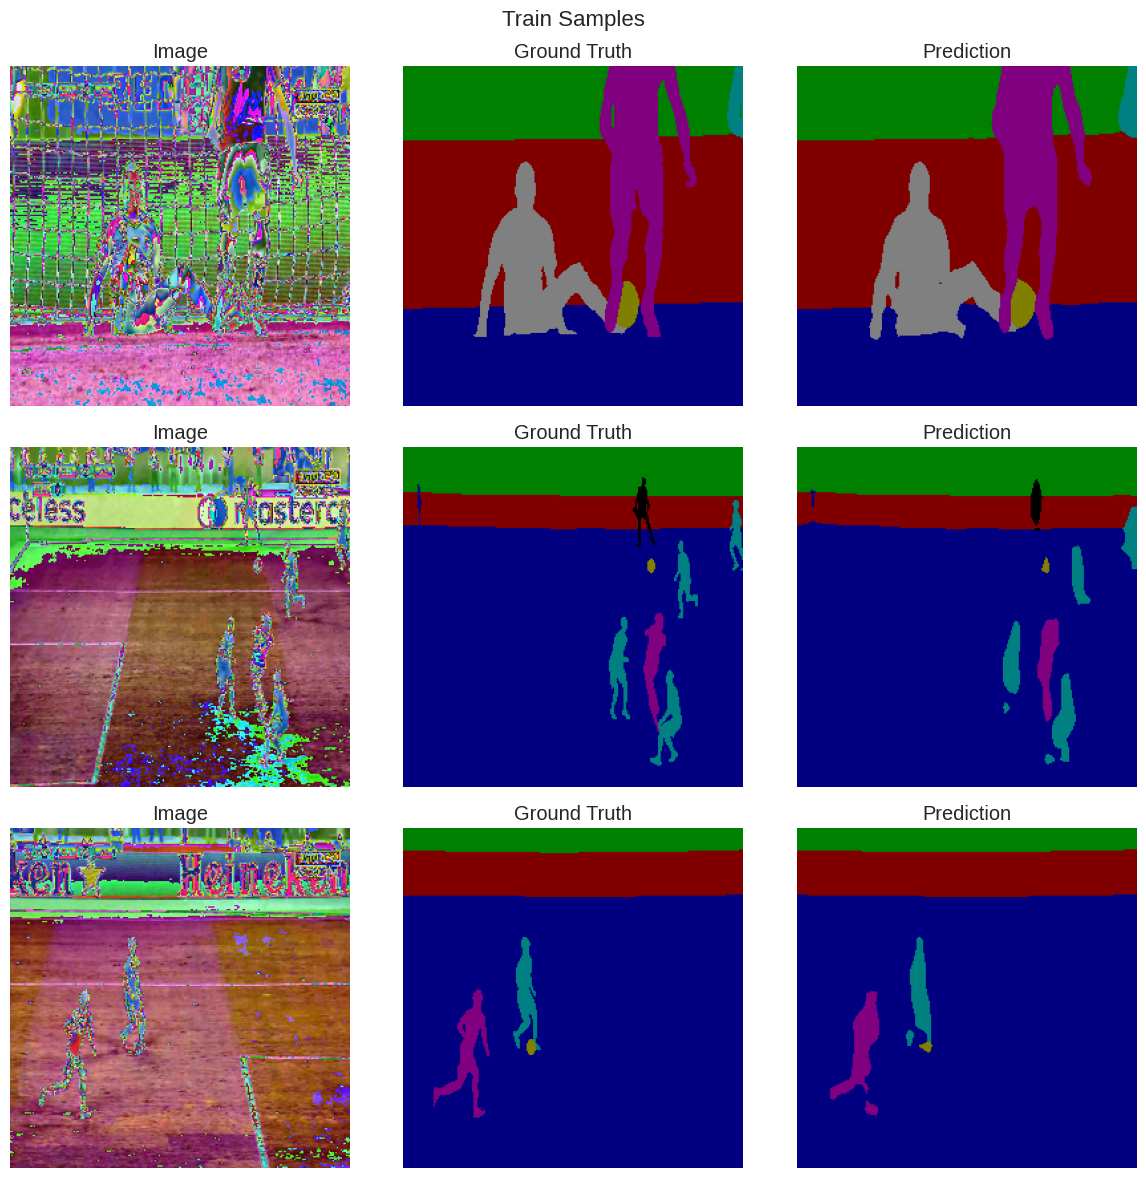

Visualizing predictions on test set:


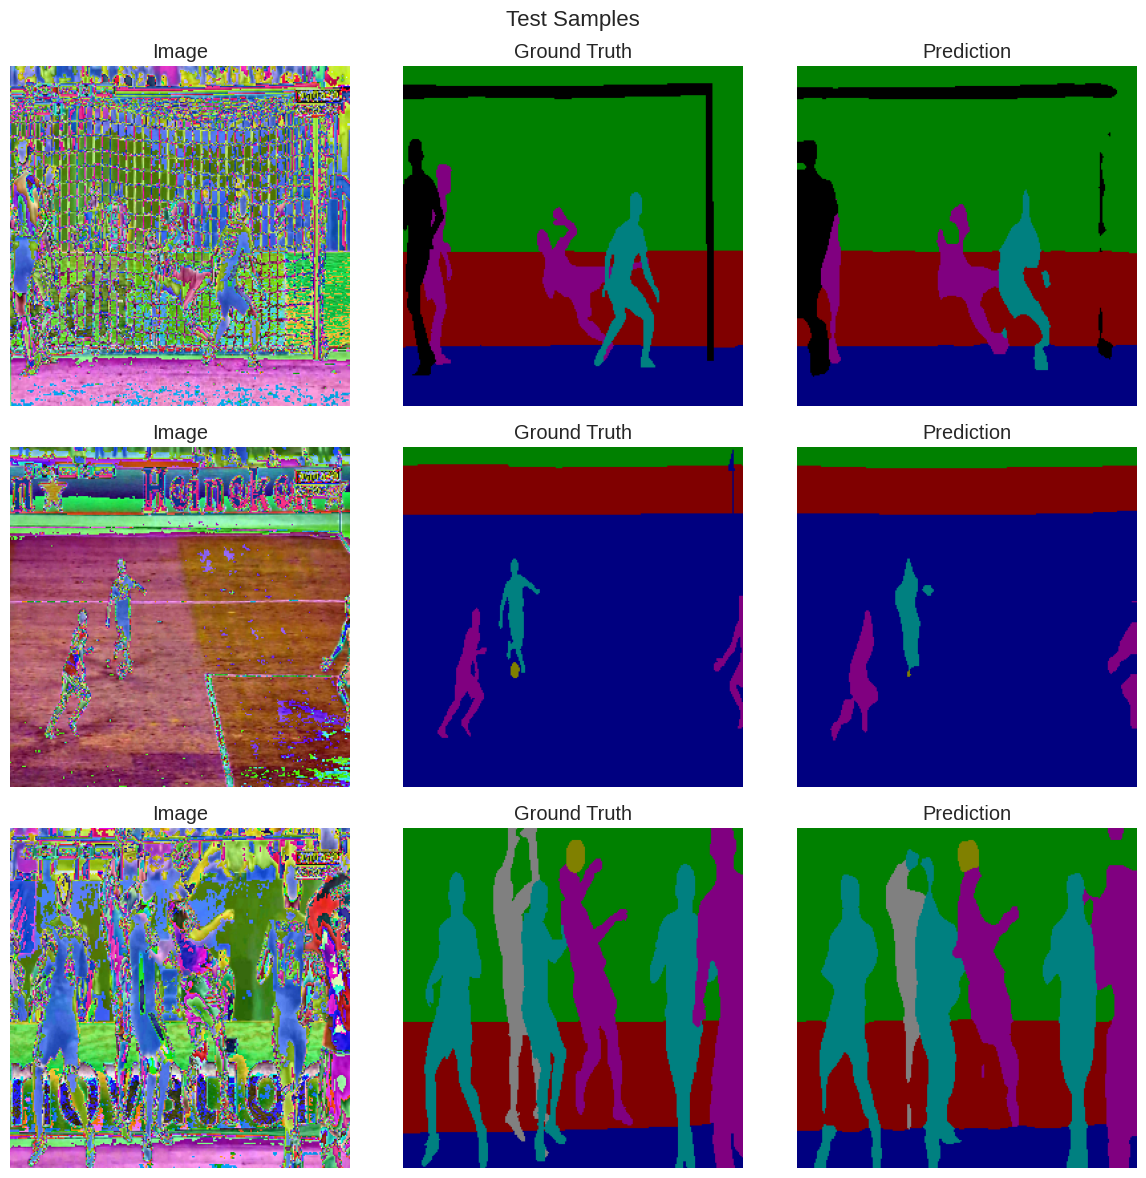

In [60]:
print("Visualizing predictions on train set:")
visualize_predictions(model, train_dataset, num_samples=3, title="Train")

print("Visualizing predictions on test set:")
visualize_predictions(model, test_dataset, num_samples=3, title="Test")